In [3]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-v0_8-notebook')

In [4]:
# Define Investment Universe
# Historical annual returns (%) for 5 assets
ASSETS = ["Stocks", "Bonds", "Real Estate", "Gold", "Cash"]
RETURNS = np.array([10.5, 5.5, 8.0, 4.5, 2.0])
RISK = np.array([15.0, 7.0, 12.0, 17.0, 0.5])

# Correlation matrix between assets
CORRELATION_MATRIX = np.array([
    [1.00, 0.20, 0.50, -0.10, 0.00],
    [0.20, 1.00, 0.30, 0.00, 0.10],
    [0.50, 0.30, 1.00, 0.00, 0.00],
    [-0.10, 0.00, 0.00, 1.00, 0.00],
    [0.00, 0.10, 0.00, 0.00, 1.00]
])

# Calculate covariance matrix
std_matrix = np.diag(RISK)
COVARIANCE_MATRIX = std_matrix @ CORRELATION_MATRIX @ std_matrix

# Display current investment universe
print("Investment Universe:")
for asset, ret, risk in zip(ASSETS, RETURNS, RISK):
    print(f"{asset:12} Return: {ret:4.1f}%  Risk: {risk:4.1f}%")

Investment Universe:
Stocks       Return: 10.5%  Risk: 15.0%
Bonds        Return:  5.5%  Risk:  7.0%
Real Estate  Return:  8.0%  Risk: 12.0%
Gold         Return:  4.5%  Risk: 17.0%
Cash         Return:  2.0%  Risk:  0.5%


In [5]:
# Portfolio Calculation Functions
def portfolio_risk(weights):
    """Calculate portfolio risk (standard deviation)"""
    return np.sqrt(weights @ COVARIANCE_MATRIX @ weights)

def portfolio_return(weights):
    """Calculate expected portfolio return"""
    return weights @ RETURNS

def objective_function(weights):
    """
    Objective: Maximize Sharpe Ratio (return/risk)
    We minimize the negative Sharpe Ratio since minimize() finds minimums
    """
    risk_free_rate = 2.0  # Assume 2% risk-free rate
    port_return = portfolio_return(weights)
    port_risk = portfolio_risk(weights)
    sharpe_ratio = (port_return - risk_free_rate) / port_risk
    return -sharpe_ratio

# Test functions with equal weights
test_weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
print(f"Test with equal weights:")
print(f"Portfolio Return: {portfolio_return(test_weights):.2f}%")
print(f"Portfolio Risk: {portfolio_risk(test_weights):.2f}%")
print(f"Sharpe Ratio: {-objective_function(test_weights):.2f}")

Test with equal weights:
Portfolio Return: 6.10%
Portfolio Risk: 6.10%
Sharpe Ratio: 0.67


In [8]:
# Optimization Setup and Execution
# Define constraints
constraints = [
    {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # weights sum to 1
    {'type': 'ineq', 'fun': lambda w: 12.0 - portfolio_risk(w)}  # risk constraint
]

# Bounds for each asset (between 0% and 40%)
bounds = [(0, 0.4) for _ in range(len(ASSETS))]

# Initial guess (equal weighting)
x0 = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

# Run optimization
result = minimize(objective_function, x0,
                 method='SLSQP',
                 bounds=bounds,
                 constraints=constraints)

# Display optimization results
print("Optimization Results:")
print(f"Success: {result.success}")
print(f"Message: {result.message}")
print("\nOptimal Portfolio Allocation:")
for asset, weight in zip(ASSETS, result.x):
    print(f"{asset:12} {weight*100:6.1f}%")
print(f"\nExpected Return: {portfolio_return(result.x):6.1f}%")
print(f"Portfolio Risk: {portfolio_risk(result.x):6.1f}%")
print(f"Sharpe Ratio: {-result.fun:.2f}")

Optimization Results:
Success: True
Message: Optimization terminated successfully

Optimal Portfolio Allocation:
Stocks         22.4%
Bonds          40.0%
Real Estate    12.1%
Gold            8.9%
Cash           16.7%

Expected Return:    6.2%
Portfolio Risk:    5.8%
Sharpe Ratio: 0.73


In [9]:
# Generate Efficient Frontier
def generate_efficient_frontier(num_portfolios=1000):
    """Generate points for efficient frontier"""
    returns_list = []
    risks_list = []
    
    for _ in range(num_portfolios):
        weights = np.random.random(len(RETURNS))
        weights = weights / np.sum(weights)
        
        port_return = portfolio_return(weights)
        port_risk = portfolio_risk(weights)
        
        returns_list.append(port_return)
        risks_list.append(port_risk)
        
    return np.array(risks_list), np.array(returns_list)

# Generate frontier points
risks, returns = generate_efficient_frontier()

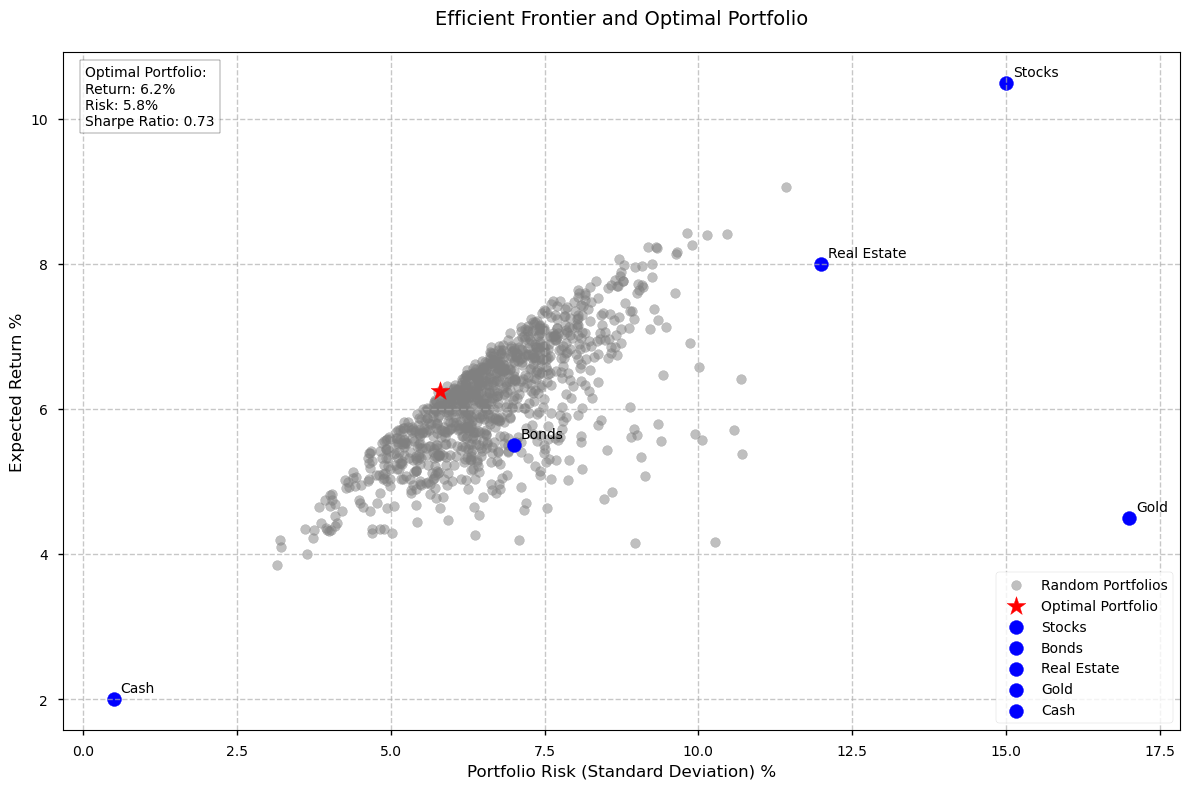

In [10]:
# Cell 6: Visualization
plt.figure(figsize=(12, 8))

# Plot random portfolios
plt.scatter(risks, returns, c='grey', alpha=0.5, label='Random Portfolios')

# Plot optimal portfolio
optimal_risk = portfolio_risk(result.x)
optimal_return = portfolio_return(result.x)
plt.scatter(optimal_risk, optimal_return, c='red', marker='*', s=200, 
            label='Optimal Portfolio')

# Plot individual assets
for i, asset in enumerate(ASSETS):
    plt.scatter(RISK[i], RETURNS[i], c='blue', marker='o', s=100, 
               label=f'{asset}')
    plt.annotate(asset, (RISK[i], RETURNS[i]), xytext=(5, 5), 
                textcoords='offset points')

# Customize plot
plt.title('Efficient Frontier and Optimal Portfolio', fontsize=14, pad=20)
plt.xlabel('Portfolio Risk (Standard Deviation) %', fontsize=12)
plt.ylabel('Expected Return %', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)

# Add text box with optimal portfolio details
textstr = '\n'.join([
    'Optimal Portfolio:',
    f'Return: {optimal_return:.1f}%',
    f'Risk: {optimal_risk:.1f}%',
    f'Sharpe Ratio: {-result.fun:.2f}'
])
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8),
         verticalalignment='top', fontsize=10)

plt.tight_layout()
plt.show()

In [12]:
# Additional Analysis
# Calculate portfolio metrics for different time periods
def stress_test_portfolio(weights, stress_returns):
    """Calculate portfolio return under different return scenarios"""
    return weights @ stress_returns

# Example stress test scenarios
stress_scenarios = {
    "Bull Market": RETURNS * 1.5,
    "Bear Market": RETURNS * 0.5,
    "Financial Crisis": RETURNS * -0.3,
    "Recovery": RETURNS * 1.2
}

print("Stress Test Results:")
for scenario, stress_returns in stress_scenarios.items():
    scenario_return = stress_test_portfolio(result.x, stress_returns)
    print(f"{scenario:16} Return: {scenario_return:6.1f}%")

Stress Test Results:
Bull Market      Return:    9.4%
Bear Market      Return:    3.1%
Financial Crisis Return:   -1.9%
Recovery         Return:    7.5%
